In [10]:
###########
# IMPORTS
###########

# Used for data structuring, and executing operations on the data present
import pandas as pd
# Used for matrix manipulation, as well as other uses
import numpy as np
# Used for data visualization
import seaborn as sns
# Used also for data visualization
import matplotlib.pyplot as plt

[Dataset](https://www.kaggle.com/datasets/sujithmandala/obesity-classification-dataset)

This dataset comprises of obesity classification among individuals, and it contains basic information like their height, weight, gender, and age. Based off that, it lists what their `label` is (what type of weight they have, normal, underweight, obese, etc). We will be extracting this data into a dataframe, and most likely processing the categorical values. After doing so, we can scale the data, and then look for any outliers among the dataset.

In [11]:
# Reading in the data
obesity_df = pd.read_csv('./Obesity Classification.csv', index_col=0)

# Printing out it's first 5 rows
obesity_df.head()

,Age,Gender,Height,Weight,BMI,Label
ID,,,,,,
1,25,Male,175,80,25.3,Normal Weight
2,30,Female,160,60,22.5,Normal Weight
3,35,Male,180,90,27.3,Overweight
4,40,Female,150,50,20.0,Underweight
5,45,Male,190,100,31.2,Obese


### 1.1 Scaling (normalizing) the data

Here we will be normalizing the data for the model, by reducing the gaps between the values, and bringing down the curve to a manageable size to pass onto the model, we can achieve a high scoring model by completing this pipeline.

In [12]:
# Used for scaling the data
from sklearn.preprocessing import StandardScaler

# Initialize scaler
scaler = StandardScaler()

continuous_columns = ['Age', 'Height', 'Weight', 'BMI']

# Take the dataframe, scale it, and create a new dataframe from the scaled values (from the original)
scaled_obesity_continuous_values = pd.DataFrame(scaler.fit_transform(obesity_df[continuous_columns]), columns=continuous_columns)

scaled_obesity_df = obesity_df.copy()
scaled_obesity_df[continuous_columns] = scaled_obesity_continuous_values

# Display the first 5 columns
scaled_obesity_df.head()

,Age,Gender,Height,Weight,BMI,Label
ID,,,,,,
1,-0.672829,Male,-0.236952,0.017730,0.258448,Normal Weight
2,-0.469625,Female,0.483917,1.062214,0.894325,Normal Weight
3,-0.266422,Male,-0.597387,-0.330431,-0.072738,Overweight
4,-0.063219,Female,0.844352,1.410375,1.410975,Underweight
5,0.139984,Male,-0.957822,-0.678592,-0.509904,Obese


### 1.2 Handling Categorical variables

Here we will be utilizing `pandas` method called `get_dummies`, which allows us to generate a modified dataframe of the original, but with all categorical columns one-hot-encoded, which assigns columns for each unique categorical value in that column, and represent whether the row had the value, which is the name of the column, present with either a 0 (for not present) or a 1 (for present)

In [13]:
## Looking at the data, we have 6 different columns, two are categorical, which we can use get_dummies to achieve the OHE of those variables
ohe_obesity_df = pd.get_dummies(scaled_obesity_df, columns=['Gender', 'Label'])

# Printing out the one-hot-encoded data
ohe_obesity_df.head()

,Age,Height,Weight,BMI,Gender_Female,Gender_Male,Label_Normal Weight,Label_Obese,Label_Overweight,Label_Underweight
ID,,,,,,,,,,
1,-0.672829,-0.236952,0.017730,0.258448,0,1,1,0,0,0
2,-0.469625,0.483917,1.062214,0.894325,1,0,1,0,0,0
3,-0.266422,-0.597387,-0.330431,-0.072738,0,1,0,0,1,0
4,-0.063219,0.844352,1.410375,1.410975,1,0,0,0,0,1
5,0.139984,-0.957822,-0.678592,-0.509904,0,1,0,1,0,0


<Axes: xlabel='0'>

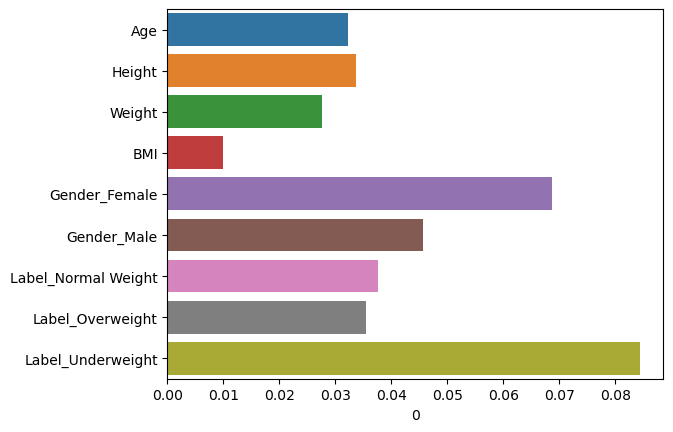

In [14]:
# Used for 
from sklearn.feature_selection import mutual_info_classif
from sklearn.impute import SimpleImputer


x = ohe_obesity_df.drop(columns=['Label_Obese'])

nan_columns = [col for col in x.columns if x[col].hasnans]

x[nan_columns] = SimpleImputer().fit_transform(x[nan_columns])

y = ohe_obesity_df['Label_Obese']

mutual_information_ratings = pd.DataFrame(mutual_info_classif(x, y).reshape(1, 9), columns=x.columns)

sns.barplot(x=mutual_information_ratings.loc[0], y=mutual_information_ratings.columns)

### 1.3 Data Analysis

As we can see from the chart, `Label_Underweight` seems to have a major correlation with `Label_Obese`, along with `Gender_Female`. `BMI` and `Height` also have really high MI scores. We can perhaps introduce a new variable called `BMI / Height`, to see if that scores high as well.

<Axes: xlabel='0'>

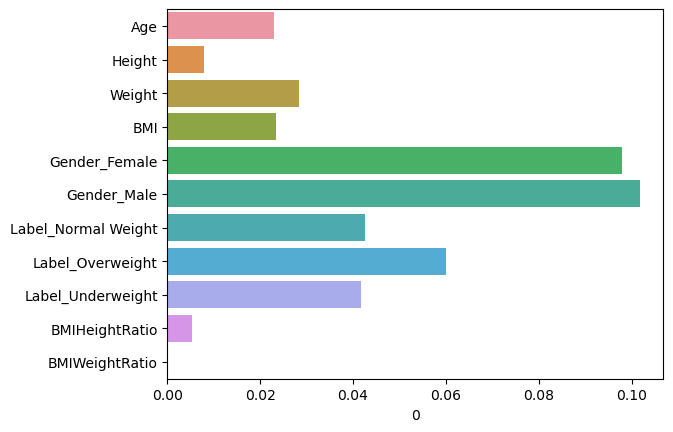

In [15]:
x_fe = x.copy()
x_fe['BMIHeightRatio'] = x_fe['BMI'] / x_fe['Height']
x_fe['BMIWeightRatio'] = x_fe['BMI'] / x_fe['Weight']

updated_mi_scores = pd.DataFrame(mutual_info_classif(x_fe, y).reshape(1, len(x_fe.columns)), columns=x_fe.columns)

sns.barplot(x=updated_mi_scores.loc[0], y=updated_mi_scores.columns)

In [16]:
from sklearn.linear_model import LogisticRegression, PassiveAggressiveClassifier, Perceptron, RidgeClassifier, SGDClassifier
from sklearn.ensemble import ExtraTreesClassifier, AdaBoostClassifier, BaggingClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

classifiers = [
    LogisticRegression(),
    PassiveAggressiveClassifier(),
    Perceptron(),
    RidgeClassifier(),
    SGDClassifier(),
    ExtraTreesClassifier(),
    AdaBoostClassifier(),
    BaggingClassifier(),
    GradientBoostingClassifier(),
    RandomForestClassifier()
]

classifier_names = []
classifier_errors = []
classifier_scores = []

train_x, test_x, train_y, test_y = train_test_split(x_fe, y)

for each_classifier in classifiers:
    each_classifier.fit(train_x, train_y)
    predictions = each_classifier.predict(test_x)
    error = mean_absolute_error(test_y, predictions)
    score = each_classifier.score(test_x, test_y)
    classifier_names.append(each_classifier.__class__.__name__)
    classifier_errors.append(error)
    classifier_scores.append(score)

Text(0.5, 0, 'Score')

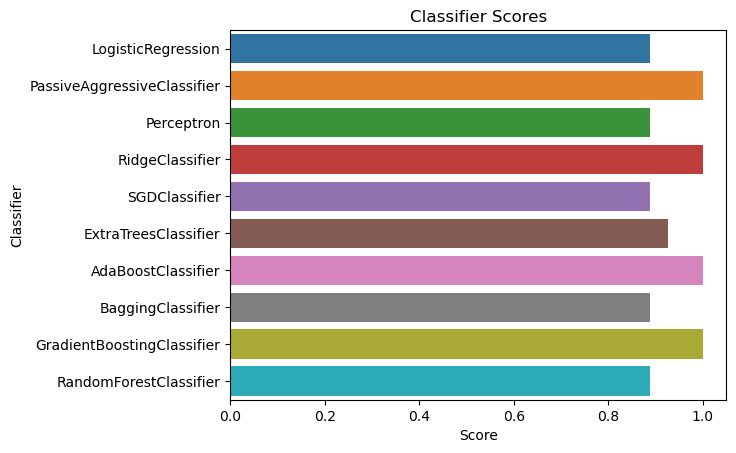

In [17]:
ax = sns.barplot(x=classifier_scores, y=classifier_names)
ax.set_ylabel("Classifier")
ax.set_title("Classifier Scores")
ax.set_xlabel("Score")

Text(0.5, 0, 'MAE')

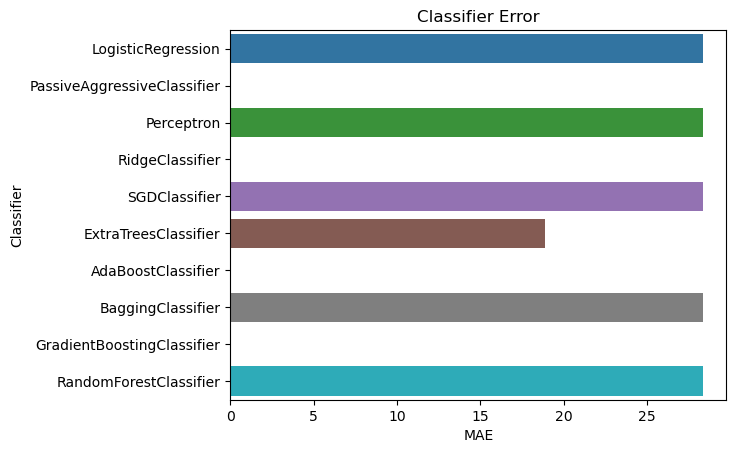

In [18]:
ax = sns.barplot(x=classifier_errors, y=classifier_names)
ax.set_ylabel("Classifier")
ax.set_title("Classifier Error")
ax.set_xlabel("MAE")

#### Judging based off of the graphs presented, we have multiple candidates for the most optimal model to predict whether someone is obese or not, dependent on the data submitted. Our candidates being PassiveAggressiveClassifier, Perceptron, RidgeClassifier, SGDClassifier, ExtraTreesClassifier, AdaBoostClassifier, and GradientBoostingClassifier. These all had basically perfect scores along with no errors in the predictions. We can submit any of these models and they will most likely have little to no variability, and low bias.